In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
cards = pd.read_csv("cards.csv")

In [3]:
train_cards, test_cards = train_test_split(cards, test_size = 0.3)

In [4]:
random.seed(0)

def generate_feature(feature, dependencies):
    keys = list(dependencies.keys())    
    cards_copy = cards.copy()
    
    for key in keys:
        cards_copy = cards_copy[(cards_copy[key] == dependencies[key])]
    try:
        return random.choice(list(cards_copy[feature]))
    except IndexError as e:
        print(feature, dependencies)
        raise(e)

def generate_nontext(cards, dependency_graph):
    """Note: keys in the dependency graph point to a list of that node's parents in the 
    dependency graph. This code assumes that the dependency_graphs keys are in order such that a node
    comes before all the node's children."""
    new_card = {}
    keys = list(dependency_graph.keys())
    for feature in keys:
        dependencies = {parent : new_card[parent] for parent in dependency_graph[feature]}
        new_card[feature] = generate_feature(feature, dependencies)
    return new_card


In [5]:
dependency_graph = {"rarity":[],
                    "color":[],
                    "type":["rarity", "color"],
                    "mana_cost":["type", "color"],
                    "power":["mana_cost", "type"],
                    "toughness":["mana_cost", "type"],
                    "loyalty":["mana_cost", "type"]}

In [6]:
rarities = []
colors = []
card_types = []
mana_costs = []
powers = []
toughnesses = []
loyalties = []

for _ in tqdm(range(test_cards.shape[0])):
    card = generate_nontext(train_cards, dependency_graph)
    rarities.append(card["rarity"])
    colors.append(card["color"])
    card_types.append(card["type"])
    mana_costs.append(card["mana_cost"])
    powers.append(card["power"])
    toughnesses.append(card["toughness"])
    loyalties.append(card["loyalty"])
    
generated_cards = pd.DataFrame({"rarity":rarities, 
                                "color":colors,
                                "type":card_types,
                                "mana_cost":mana_costs,
                                "power":powers,
                                "toughness":toughnesses,
                                "loyalty":loyalties})

100%|██████████████████████████████████████████████████████████████████████████████| 5241/5241 [01:34<00:00, 55.64it/s]


In [14]:
def count_same(row, df):
    df = df.copy()
    for s in [
        "rarity", 
        "color", 
        "type",
        "mana_cost",
        #"power",
        #"toughness",
        #"loyalty"
    ]:
        df = df[(df[s] == row[s])]
    return df.shape[0]

C:\Users\jayma\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

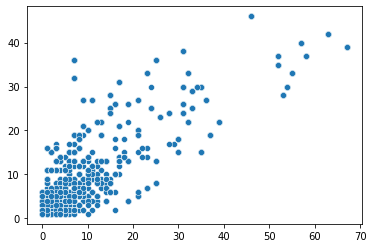

In [15]:
test_same, gen_same = [],[]
unique_generated_cards = generated_cards.drop_duplicates()
for index, row in unique_generated_cards.iterrows():
    test_same.append(count_same(row, test_cards))
    gen_same.append(count_same(row, generated_cards))

sns.scatterplot(test_same, gen_same)

In [17]:
margin = 9
reasonably_close = [g <= t+margin and g >= t-margin for t, g in zip(test_same, gen_same)]
np.mean(reasonably_close)

0.8145129996119519

In [10]:
for t_ in range(300):
    for g_ in range(300):
        count_stats = [t == t_ and g == g_ for t, g in zip(test_same, gen_same)]
        if any(count_stats):
            print(t_, g_, np.mean(count_stats))

0 1 0.013193636010865347
0 2 0.005820721769499418
0 3 0.0019402405898331393
0 4 0.002328288707799767
0 5 0.0015521924718665113
1 1 0.008149010477299184
1 2 0.006984866123399301
1 3 0.004656577415599534
1 4 0.004268529297632906
1 6 0.0015521924718665113
1 9 0.0015521924718665113
2 1 0.0038804811796662787
2 2 0.004656577415599534
2 3 0.0011641443538998836
2 4 0.0007760962359332557
2 5 0.0011641443538998836
2 7 0.0015521924718665113
2 8 0.002716336825766395
2 9 0.002328288707799767
2 12 0.002328288707799767
2 14 0.004268529297632906
3 1 0.0031043849437330227
3 2 0.002328288707799767
3 3 0.0038804811796662787
3 4 0.0034924330616996507
3 5 0.0015521924718665113
4 1 0.0011641443538998836
4 2 0.0007760962359332557
4 3 0.0031043849437330227
4 4 0.0011641443538998836
4 5 0.006208769887466045
4 6 0.0011641443538998836
4 7 0.002328288707799767
4 14 0.010089251067132324
5 1 0.0011641443538998836
5 2 0.0007760962359332557
5 3 0.0011641443538998836
5 4 0.0015521924718665113
5 6 0.0038804811796662787